# Customer Churn Prediction (Advanced Dataset)

**Objective:** Predict customer churn using a richer synthetic dataset (10,000 rows) that simulates real-world patterns. The notebook includes EDA, feature engineering, model training (including hyperparameter tuning), and interpretation using SHAP.

**Note:** The notebook contains optional Kaggle download instructions for the Telco Customer Churn dataset if you prefer the real dataset.

## Setup
```bash
pip install pandas scikit-learn shap matplotlib seaborn xgboost kaggle
```

In [13]:
import pandas as pd
df = pd.read_csv('data_churn_advanced.csv')
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MonthlyCharges,TotalCharges,Contract,PaymentMethod,Churn
0,C100000,Female,0,No,Yes,26,Yes,108.69,2797.46,Two year,Credit card,No
1,C100001,Male,0,No,Yes,26,Yes,21.64,536.02,Month-to-month,Bank transfer,Yes
2,C100002,Female,1,No,No,27,Yes,18.00,471.64,Month-to-month,Electronic check,No
3,C100003,Female,0,Yes,No,23,Yes,92.22,2119.42,One year,Electronic check,No
4,C100004,Female,1,Yes,No,25,Yes,60.06,1537.92,Two year,Bank transfer,No


## EDA & Feature Engineering

(10000, 12)
Churn
No     0.802
Yes    0.198
Name: proportion, dtype: float64


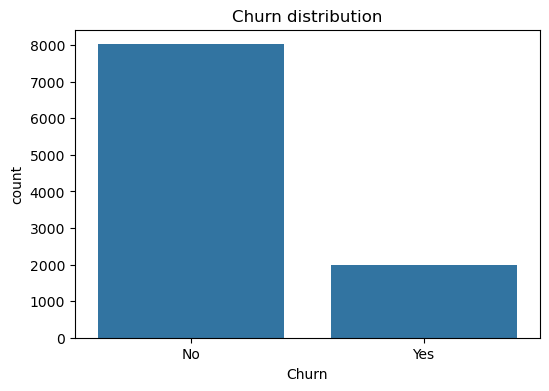

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
print(df.shape)
print(df['Churn'].value_counts(normalize=True))
plt.figure(figsize=(6,4)); sns.countplot(x='Churn', data=df); plt.title('Churn distribution'); plt.show()

In [18]:
# Simple preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
X = df.drop(['customerID','Churn'], axis=1)
y = (df['Churn']=='Yes').astype(int)
X = pd.get_dummies(X, drop_first=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_train.shape

(8000, 13)

## Model: XGBoost with RandomizedSearchCV

In [26]:
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import roc_auc_score, classification_report
import warnings

# Suppress harmless warnings
warnings.filterwarnings("ignore", category=UserWarning)

# Updated model (removed deprecated use_label_encoder)
model = XGBClassifier(
    eval_metric='logloss',
    random_state=42,
    n_jobs=4
)

# Parameter grid for tuning
param_dist = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.05, 0.1]
}

# Randomized search for best hyperparameters
search = RandomizedSearchCV(
    model,
    param_distributions=param_dist,
    n_iter=6,
    scoring='roc_auc',
    cv=3,
    random_state=42,
    n_jobs=-1
)

# Fit the model
search.fit(X_train, y_train)

# Display results
print("Best params:", search.best_params_)

# Predictions
preds = search.predict(X_test)
probs = search.predict_proba(X_test)[:, 1]

# Evaluation metrics
print("\nClassification Report:")
print(classification_report(y_test, preds, zero_division=1))
print("ROC AUC:", roc_auc_score(y_test, probs))


Best params: {'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.01}

Classification Report:
              precision    recall  f1-score   support

           0       0.80      1.00      0.89      1604
           1       1.00      0.00      0.00       396

    accuracy                           0.80      2000
   macro avg       0.90      0.50      0.45      2000
weighted avg       0.84      0.80      0.71      2000

ROC AUC: 0.7643698518854379


## Model interpretation with SHAP (global feature importance)

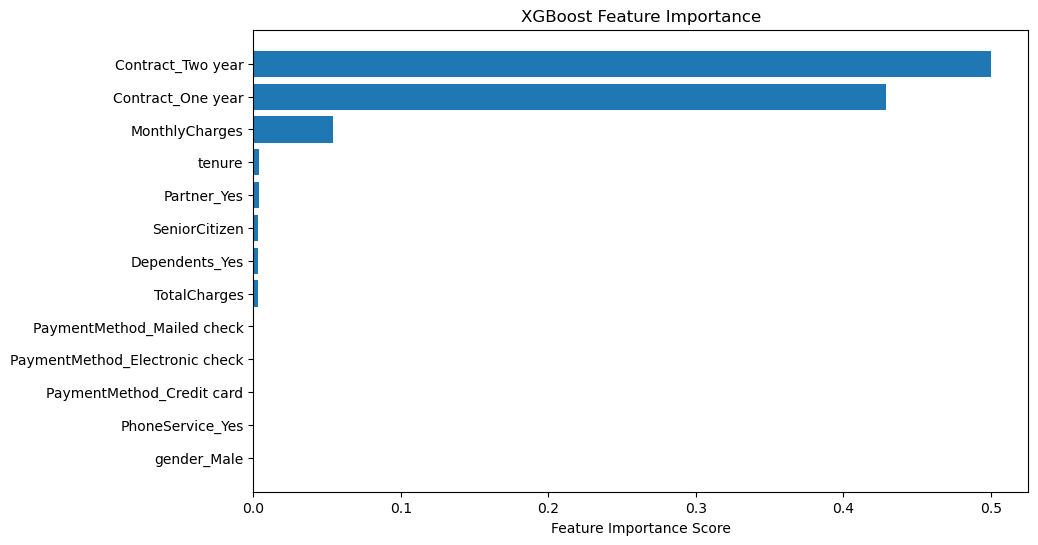

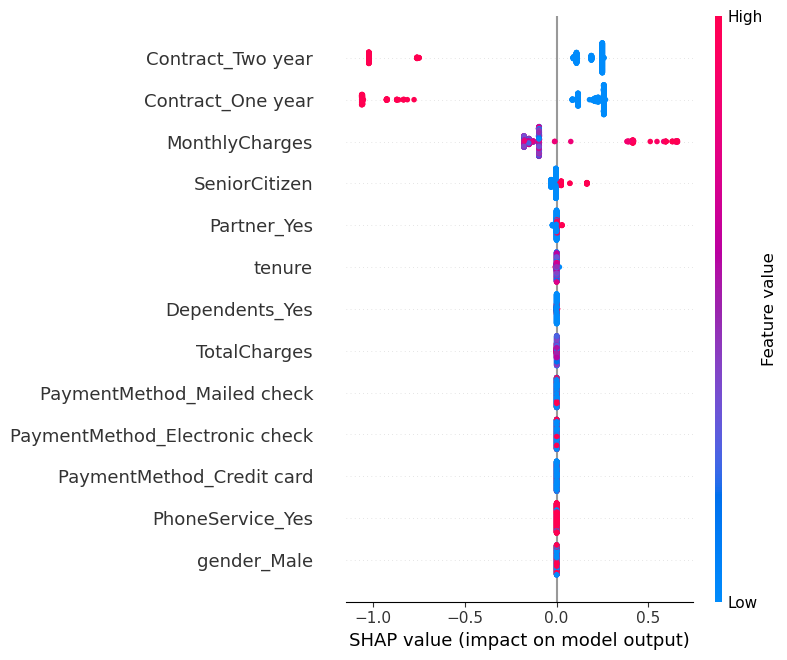

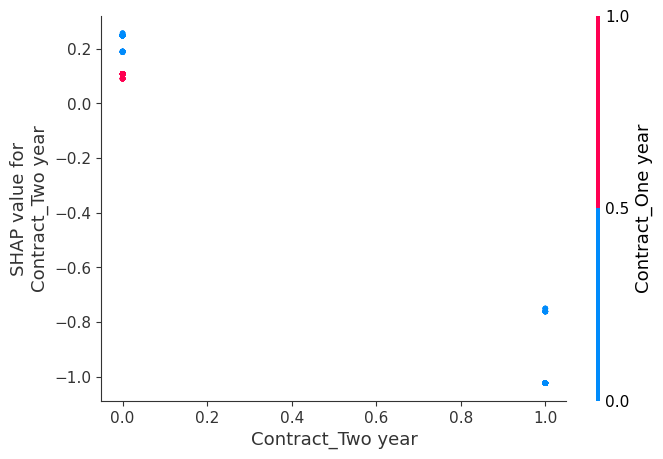

In [48]:
# --- Model Interpretation for XGBoost ---
import shap
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Use the best trained model from RandomizedSearchCV
best_model = search.best_estimator_

# --- Feature Importance (XGBoost built-in) ---
plt.figure(figsize=(10, 6))
xgb_importances = best_model.feature_importances_
sorted_idx = np.argsort(xgb_importances)[::-1]
plt.barh(range(len(sorted_idx)), xgb_importances[sorted_idx])
plt.yticks(range(len(sorted_idx)), np.array(X_train.columns)[sorted_idx])
plt.xlabel("Feature Importance Score")
plt.title("XGBoost Feature Importance")
plt.gca().invert_yaxis()
plt.show()

# --- SHAP Summary Plot (Global Interpretation) ---
# Explain predictions using SHAP values
explainer = shap.TreeExplainer(best_model)

# Sample smaller subset to speed up computation if dataset is large
X_sample = X_test.sample(500, random_state=42) if len(X_test) > 500 else X_test
shap_values = explainer.shap_values(X_sample)

# Summary plot (feature impact and importance)
shap.summary_plot(shap_values, X_sample, show=True)

# --- SHAP Dependence Plot (Feature-level interaction) ---
# Choose one of the most important features (based on SHAP summary)
top_feature = X_sample.columns[np.argsort(np.abs(shap_values).mean(0))[-1]]
shap.dependence_plot(top_feature, shap_values, X_sample)

# --- SHAP Force Plot (Individual Prediction Explanation) ---
# Explain a single prediction
idx = 0  # choose any test instance
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[idx, :], X_sample.iloc[idx, :])


## Optional: Download Telco Customer Churn from Kaggle
```python
# from kaggle.api.kaggle_api_extended import KaggleApi
# api=KaggleApi(); api.authenticate()
# api.dataset_download_files('blsantos/telco-customer-churn', path='.', unzip=True)
```